In [1]:
#company hierarchy

In [2]:
import pandas as pd

import plotly.graph_objects as go

import networkx as nx
import ast

In [3]:
data = pd.read_csv("company_master_table.csv", 
                   dtype={"child_cw_id_list" :'str',
                          "parent_cw_id_list": 'str'}, converters={1:ast.literal_eval})

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
CW_ID = 'cw_id'
INDUSTRY_NAME = 'industry_name'
SECTOR_NAME = 'sector_name'
NUM_PARENTS = 'num_parents'
NUM_CHILDREN = 'num_children'
TOP_PARENT_ID = 'top_parent_id'
COMPANY_NAME = 'company_name'
CHILD_CW_ID_LIST = 'child_cw_id_list'
PARENT_CW_ID_LIST = 'parent_cw_id_list'


In [5]:
def list_parse(s):
    strings = str(s).strip("[]").split(",")
    ls = []
    for i in strings:
        try:
            ls.append(int(float(i.strip())))
        except (ValueError):
            ""
    return ls

In [6]:
list_parse("[  6.0   ,nan   ,     7.0]")

[6, 7]

In [7]:
data[CHILD_CW_ID_LIST] = data[CHILD_CW_ID_LIST].apply(lambda x: list_parse(x))
data[PARENT_CW_ID_LIST] = data[PARENT_CW_ID_LIST].apply(lambda x: list_parse(x))

In [8]:
x = data[CHILD_CW_ID_LIST]
x[1][0]

1038175

In [9]:
families = data[((data[NUM_PARENTS]> 0) | (data[NUM_CHILDREN] > 0))]  #i might not want to do this

In [10]:
families.shape

(573820, 23)

In [11]:
family_groups = families.groupby(families[TOP_PARENT_ID])

In [12]:
def unique_non_nan(elem):
    return [a for a in list(pd.unique(elem)) if pd.notna(a)]

def print_list_columns(df, column_name):
    d = df[column_name].to_dict()
    for k in d:
        print(str(k) + ":")
        values = d[k]
        for v in values: 
            print("\t \t \t" + v)


In [13]:
def create_co_report(group_df, company_id, name_string):
    
    agg_dictionary = {"row_id" : "count",
                  CW_ID: unique_non_nan,
                  COMPANY_NAME: unique_non_nan,
                 }
    COMPANY_COUNT = "company_count"
    industry_df = group_df.groupby(by = "industry_name").agg(agg_dictionary)
    industry_df.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    top_industries_df = industry_df.sort_values(by = COMPANY_NAME, ascending=False)
    top_industries = [k for k in top_industries_df[COMPANY_COUNT].to_dict().keys()]
    
    sectors = group_df.groupby(SECTOR_NAME).count() 
    sectors.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    
    #summary:     
    print("Company "  + str(name_string) + " has " + str(group_df.shape[0]) + " subsidiaries")
   
    #change to take the top 3 or so industries if they exist 
    print("Top industries " + str(top_industries))
    
    # needs to be renamed to the count
    
    industry_df.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries By Industry") 
    plt.show()
    #maybe print top sectors???? 
    sectors.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries by Sector")
    plt.show()
    print("==================== SUBSIDIARIES BY INDUSTRY ============================= ")
    
    print_list_columns(industry_df, COMPANY_NAME)

In [14]:
family_graph = {}

from collections import defaultdict
#Loop through the top parent ids
#relationships are parent ---> child 
from collections.abc import Iterable   # import directly from collections for Python < 3.3
failed_rows = 0
for name, group in family_groups:
    G = nx.DiGraph()
    for index, row in group.iterrows():
        cw_id = int(row[CW_ID])
        children = row[CHILD_CW_ID_LIST]
        parents = row[PARENT_CW_ID_LIST]
        try:
            for c in children:
                if(c != cw_id):
                    G.add_edge(cw_id, c)
            for p in parents:
                if p != cw_id:
                    G.add_edge(p, cw_id)
        except (ValueError):
            print("?")
        family_graph[name] = G


In [15]:
#H.add_nodes_from([1,3,4,5])
import math
J = nx.DiGraph()
J.add_edges_from([(1,2.0), (3, 2) , (3,4), (int(8.0), 9)])

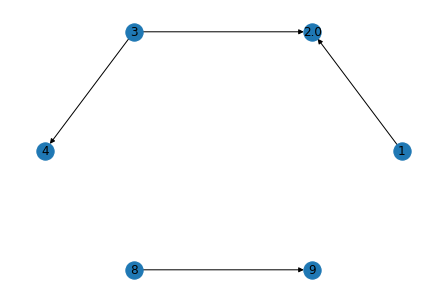

In [16]:
%matplotlib inline  
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
def plot_graph(G):
    nx.draw_shell(G, with_labels=True)
    plt.show()
g = family_graph[130]

plot_graph(J)

In [17]:
family_graph[130].edges

OutEdgeView([(1280, 1048675), (1280, 1011579), (1280, 1196), (1280, 1180), (907597, 1280), (118277, 118278), (841127, 118282), (841127, 118283), (841127, 1001726), (118283, 1113459), (590084, 130), (42654, 590084), (42654, 914312), (42654, 1004428), (42654, 1048674), (743580, 644548), (743580, 702436), (743580, 702625), (743580, 788091), (743579, 702874), (788091, 788220), (1001713, 590086), (788089, 1001713), (971904, 1001727)])

In [18]:
g.subgraph([75, 120]).edges

OutEdgeView([])

In [19]:
indexed_groups = families.set_index(CW_ID) ## should not use the filtered list 
    

In [20]:
indexed_groups.loc[75]

def get_name_by_id(index_df, cw_id):
    row = index_df.loc[cw_id]
    return row[COMPANY_NAME]

In [21]:
get_name_by_id(indexed_groups, 37)

'ALABAMA POWER CO'

In [22]:
family_groups.get_group(37).groupby("num_children").count()

,Unnamed: 0,row_id,cw_id,most_recent,year,cik,irs_number,best_location_id,sic_code,industry_name,...,source_type,source_id,num_parents,top_parent_id,company_name,max_year,min_year,no_sic,child_cw_id_list,parent_cw_id_list
num_children,,,,,,,,,,,,,,,,,,,,,
0,4,4,4,4,4,4,0,4,0,0,...,4,4,4,4,4,4,4,4,4,4
2,1,1,1,1,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
101,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [27]:
def generate_company_report(company_id):
    co_name = get_name_by_id(indexed_groups, company_id)
    row = indexed_groups.loc[company_id]
    industry = row[INDUSTRY_NAME]
    parents = row[PARENT_CW_ID_LIST]
    top_parent = row[TOP_PARENT_ID]
    print("Company: " + co_name + "  company_id: " + str(company_id))
    print("=====================")
    print("")
    
    #size by industry, number of subsidiaries
    
    if top_parent != cw_id:
        top_parent_name = get_name_by_id(indexed_groups, top_parent)
        print("Is a subsidiary of: " + str(top_parent_name) + " ( " + str(top_parent) + " )")
        
        #Ask the user if they would like to see the top parent report before showing it? 
        group = family_groups.get_group(top_parent)
        create_co_report(group, top_parent, top_parent_name)
    else:
        print("The company has no parents")

    #wish list 
    #is a multinational
    #ranking by industry
    #number of child locations
    #subsidiaries locations


Company: Parrey LLC  company_id: 980545

Is a subsidiary of: GEORGIA POWER CO ( 781 )
Company GEORGIA POWER CO has 162 subsidiaries
Top industries ['Natural gas distribution', 'Electric services']


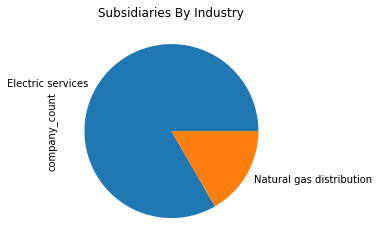

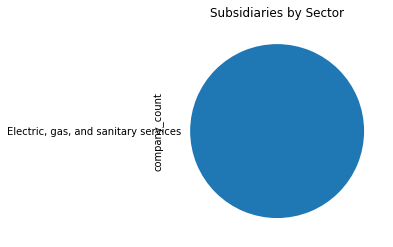

==================== SUBSIDIARIES BY INDUSTRY ============================= 
Electric services:
	 	 	GEORGIA POWER CO
	 	 	MISSISSIPPI POWER CO
	 	 	SOUTHERN CO
	 	 	GULF POWER CAPITAL TRUST I
	 	 	GULF POWER CAPITAL TRUST II
Natural gas distribution:
	 	 	SOUTHERN Co GAS


In [28]:
generate_company_report(980545)

Company: GEORGIA POWER CO  company_id: 781

Is a subsidiary of: GEORGIA POWER CO ( 781 )
Company GEORGIA POWER CO has 162 subsidiaries
Top industries ['Natural gas distribution', 'Electric services']


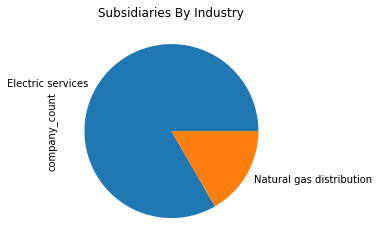

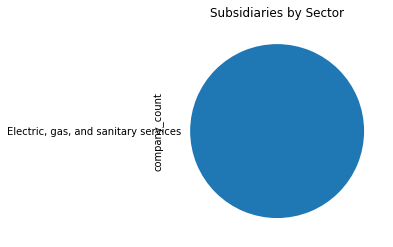

==================== SUBSIDIARIES BY INDUSTRY ============================= 
Electric services:
	 	 	GEORGIA POWER CO
	 	 	MISSISSIPPI POWER CO
	 	 	SOUTHERN CO
	 	 	GULF POWER CAPITAL TRUST I
	 	 	GULF POWER CAPITAL TRUST II
Natural gas distribution:
	 	 	SOUTHERN Co GAS


In [29]:
generate_company_report(781)